In [1]:
%load_ext autoreload
%autoreload 2

import json

import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier

from htc_projects.sepsis_icu.baseline_methods import classifier_results
from htc_projects.sepsis_icu.settings_sepsis_icu import settings_sepsis_icu
from htc_projects.sepsis_icu.utils import config_from_baseline_name, save_figure

In [2]:
font_size = 8
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Myriad Pro"
plt.rcParams["font.size"] = font_size
plt.rcParams["xtick.labelsize"] = font_size
plt.rcParams["ytick.labelsize"] = font_size
cmap = "Greens"

In [3]:
def plot_feature_importance(timedelta: int = 1):
    metadata_ranking_path = settings_sepsis_icu.results_dir / "feature_importance_rankings.json"
    with metadata_ranking_path.open("r") as f:
        metadata_ranking_dict = json.load(f)

    if timedelta == 1:
        groups = "demographic+vital+BGA+diagnosis+ventilation+catecholamines"
    elif timedelta == 10:
        groups = "demographic+vital+BGA+diagnosis+ventilation+catecholamines+lab"
    run_dir = "random_forest_meta@" + groups

    targets = ["sepsis", "survival"]
    fig, ax = plt.subplots(
        len(targets),
        1,
        figsize=(settings_sepsis_icu.page_width_inch, 6),
    )
    plt.subplots_adjust(left=0.02, right=0.99, top=1, bottom=0, hspace=3)

    attribution_dict = {}
    for i, target in enumerate(targets):
        # compute feature importance
        config = config_from_baseline_name(run_dir, target)
        res = classifier_results(RandomForestClassifier, config, class_weight="balanced", test_results=False)
        attributions = res["attributions"]
        attributions = np.mean(attributions, axis=0)  # average across folds

        # sort according to metadata ranking
        metadata_ranking = metadata_ranking_dict[target][str(timedelta)]
        feature_order = [a["name"] for a in config["input/meta/attributes"]]
        feature_index = [feature_order.index(a) for a in metadata_ranking]
        attributions = attributions[feature_index]
        attribution_dict[target] = attributions

    # plot
    vmin = min([np.min(attribution_dict[target]) for target in targets])
    vmax = max([np.max(attribution_dict[target]) for target in targets])
    for i, target in enumerate(targets):
        im = ax[i].imshow(
            attribution_dict[target].reshape(1, -1),
            cmap=cmap,
            # aspect="auto",
            vmin=vmin,
            vmax=vmax,
        )
        ax[i].set_yticks([])
        ax[i].set_xticks(np.arange(len(attribution_dict[target])))
        xticklabels = metadata_ranking_dict[target][str(timedelta)]
        xticklabels = [
            settings_sepsis_icu.metadata_paper_renaming[l]
            if l in settings_sepsis_icu.metadata_paper_renaming.keys()
            else l
            for l in xticklabels
        ]
        xticklabels = [l.replace("_", " ") for l in xticklabels]
        ax[i].set_xticklabels(xticklabels, rotation=90)
        ax[i].tick_params(axis="x", which="major", pad=15)

    cbar = fig.colorbar(im, ax=ax.ravel().tolist(), pad=0.3, aspect=35, orientation="horizontal")
    cbar.set_label("feature importance [a.u.]")

    savepath = settings_sepsis_icu.results_dir / "paper_figures" / f"Clinical_data_importance_{timedelta}hours.pdf"
    savepath.parent.mkdir(parents=True, exist_ok=True)
    save_figure(savepath, fig, dpi=600)

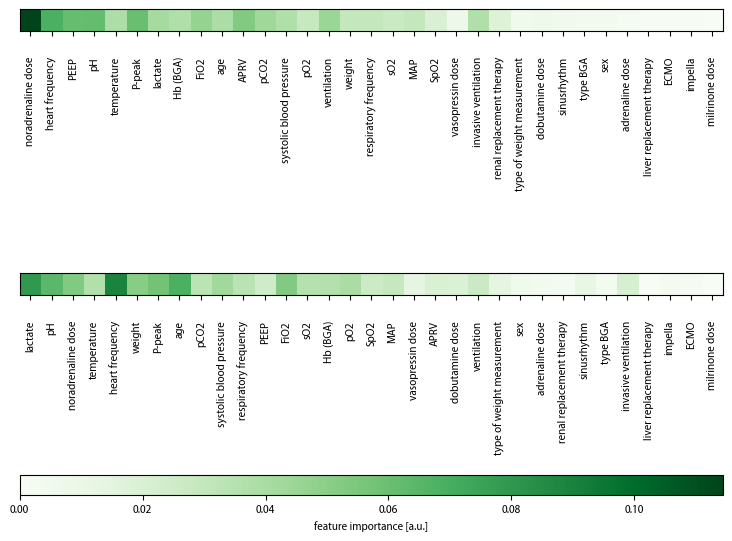

In [4]:
plot_feature_importance()

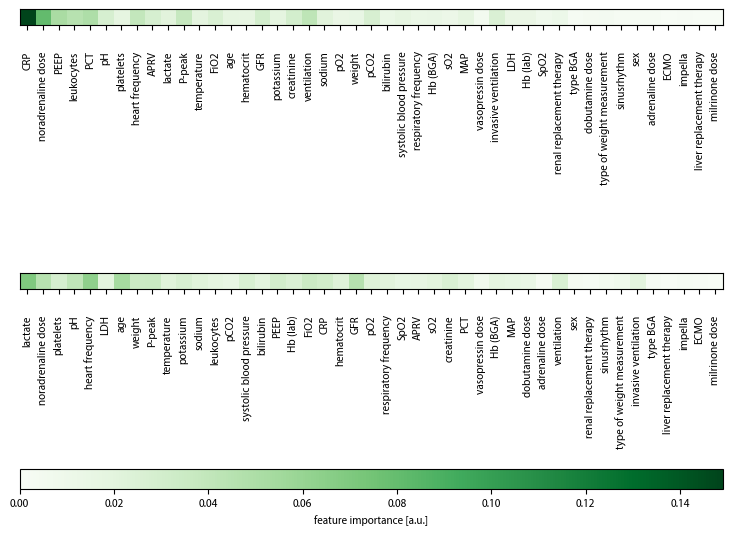

In [5]:
plot_feature_importance(10)